## **SERVER - FEDERATED LEARNING**

### Imports

In [ ]:
!pip install segmentation-models-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 43.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 28.6 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16444 sha256=e58c0e8fc79c5793bafc52413a34e968d0ea54820bc1c35b360952af5f371f54
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=680d394ddc885e7a55357ab02972856b9192982fefd4f4c994a7d5cf1689fa92
  Stored in directory: /root/.cache/pip/w

In [ ]:
import nibabel as nib
import time
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.models.feature_extraction import create_feature_extractor

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K

import segmentation_models_pytorch as smp

## 1. FEDERATED LEARNING for UNET 3D

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.metrics import MeanIoU

kernel_initializer =  'he_uniform' #Try others if you want


################################################################
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)

    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)

    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)

    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)

    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)

    #Expansive path
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)

    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)

    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)

    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)

    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [ ]:
model = simple_unet_model(IMG_HEIGHT=144,
                          IMG_WIDTH=144,
                          IMG_DEPTH=144,
                          IMG_CHANNELS=3,
                          num_classes=4)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.models import load_model
# from keras.models import load_model

model1 = model
model2 = model
averaged_model = model

# Load the first hdf5 file
model1.load_weights('/content/drive/MyDrive/BraTS2020_TrainingData/brats_3d_144.hdf5')

# Load the second hdf5 file
model2.load_weights('/content/drive/MyDrive/BraTS2020_TrainingData/brats_3d_144_2.hdf5')

averaged_weights = []
for i in range(len(model1.layers)):
    weights1 = model1.layers[i].get_weights()
    weights2 = model2.layers[i].get_weights()
    averaged_weights.append([(w1 + w2) / 2 for w1, w2 in zip(weights1, weights2)])

# Create a new model with the same architecture as the original model
averaged_model.load_weights('/content/drive/MyDrive/BraTS2020_TrainingData/brats_3d_144.hdf5')

# Set the weights of each layer in the new model to the corresponding average weights
for i in range(len(averaged_model.layers)):
    averaged_model.layers[i].set_weights(averaged_weights[i])

# Save the averaged weights to a new hdf5 file
averaged_model.save('/content/drive/MyDrive/BraTS2020_TrainingData/averaged_model.hdf5')


1/1 [==============================] - 0s 57ms/step


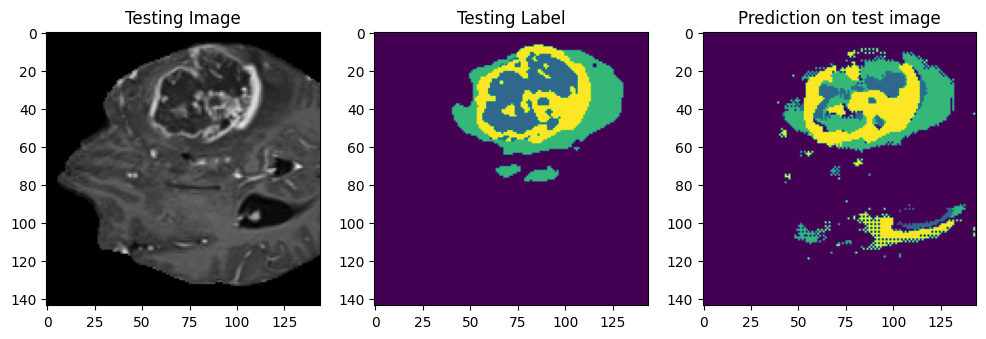

In [ ]:

#############################################
#Predict on a few test images, one at a time
#Try images:
img_num = 123

test_img = np.load("/content/drive/MyDrive/BraTS2020_TrainingData/input_data_144/val/images/image_"+str(img_num)+".npy")

test_mask = np.load("/content/drive/MyDrive/BraTS2020_TrainingData/input_data_144/val/masks/mask_"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = averaged_model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]


# print(test_prediction_argmax.shape)
# print(test_mask_argmax.shape)
# print(np.unique(test_prediction_argmax))


#Plot individual slices from test predictions for verification
from matplotlib import pyplot as plt
import random

#n_slice=random.randint(0, test_prediction_argmax.shape[2])
n_slice = 55
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()

## 2. Federated on DeepLabV3

In [ ]:
def convolution_block(block_input,num_filters=128, kernel_size=3, dilation_rate=1, padding="same", use_bias=False):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal())(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def AtrousSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)
    print("Inside dspp, out_pool: ", out_pool.shape)
    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

In [ ]:
resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_shape = (240,240,3))
resnet50.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 246, 246, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 120, 120, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model

def DeepLabv3(input_shape, num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    input_tensor = Input(shape=input_shape)
    x = base_model(input_tensor)
    dilations = [6, 12, 18]
    aspp_layers = []
    for dilation_rate in dilations:
        aspp_layer = Conv2D(filters=256, kernel_size=1, activation='relu')(x)
        aspp_layer = Conv2D(filters=256, kernel_size=3, dilation_rate=dilation_rate, padding='same', activation='relu')(aspp_layer)
        aspp_layers.append(aspp_layer)
    merged = tf.concat(aspp_layers, axis=-1)
    x = Conv2D(filters=256, kernel_size=1, activation='relu')(merged)
    x = Conv2DTranspose(filters=256, kernel_size=3, strides=2, padding='same', activation='relu')(x)
    mask = Conv2D(filters=num_classes, kernel_size=1, activation='softmax')(x)
    model = Model(inputs=input_tensor, outputs=mask)

    return model

In [ ]:
IMAGE_SIZE = 240
NUM_CLASSES = 4
model_dlv = DeeplabV3(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)

In [ ]:
from tensorflow.keras.models import load_model
# from keras.models import load_model

model_dlv1 = model_dlv
model_dlv2 = model_dlv
averaged_model_dlv = model_dlv

# Load the first hdf5 file
model_dlv1.load_weights('/content/drive/MyDrive/BraTS2020_TrainingData/brats_3d_deeplabv3.hdf5')

# Load the second hdf5 file
model_dlv2.load_weights('/content/drive/MyDrive/BraTS2020_TrainingData/brats_3d_deeplabv3_2.hdf5')

averaged_weights = []
for i in range(len(model_dlv1.layers)):
    weights1 = model_dlv1.layers[i].get_weights()
    weights2 = model_dlv2.layers[i].get_weights()
    averaged_weights.append([(w1 + w2) / 2 for w1, w2 in zip(weights1, weights2)])

# Create a new model with the same architecture as the original model
averaged_model_dlv.load_weights('/content/drive/MyDrive/BraTS2020_TrainingData/brats_3d_deeplabv3.hdf5')

# Set the weights of each layer in the new model to the corresponding average weights
for i in range(len(averaged_model_dlv.layers)):
    averaged_model_dlv.layers[i].set_weights(averaged_weights[i])

# Save the averaged weights to a new hdf5 file
averaged_model_dlv.save('/content/drive/MyDrive/BraTS2020_TrainingData/averaged_model_deeplab.hdf5')

In [ ]:
train_images_paths = sorted(glob.glob('/content/drive/MyDrive/Dataset_BraTS/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1.nii'))
train_masks_paths = sorted(glob.glob('/content/drive/MyDrive/Dataset_BraTS/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*seg.nii'))
x_train, x_test, y_train, y_test = train_test_split(train_images_paths, train_masks_paths, test_size=0.1, random_state=52)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=52)

1/1 [==============================] - 0s 25ms/step


Text(0.5, 1.0, 'Predicted')

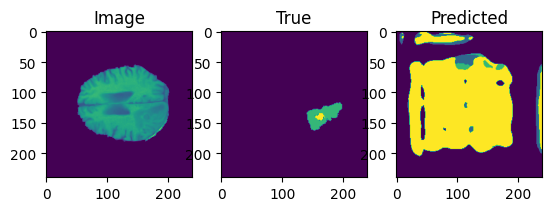

In [ ]:
test_image = nib.load(x_train[1]).get_fdata()
test_image = test_image/np.max(test_image)
test_image = test_image.astype(np.float32)
test_image_slice = np.repeat(test_image[:,:,100][...,np.newaxis], 3, axis=-1)
test_image_slice = test_image_slice[np.newaxis,...]

mask = nib.load(y_train[1]).get_fdata()
mask[mask==4] = 3
pred = averaged_model_dlv.predict(test_image_slice)[0]
# predictions = np.squeeze(pred)
predictions = np.argmax(pred, axis=2)
plt.subplot(131)
plt.imshow(test_image[:,:,100])
plt.title('Image')
plt.subplot(132)
plt.imshow(mask[:,:,100])
plt.title('True')
plt.subplot(133)
plt.imshow(predictions)
plt.title("Predicted")